# Deppfake Detection Training

In [ ]:
!pip install keras-tuner
!pip install ultralytics

In [ ]:
from google.colab import drive
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import RandomRotation, RandomFlip, GaussianNoise , RandomContrast, Resizing, Rescaling, Conv2D, BatchNormalization, MaxPool2D, SeparableConv2D, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import keras_tuner as kt
from ultralytics import YOLO

logging.getLogger('ultralytics').setLevel(logging.ERROR)


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
CONFIGURATION = {
    "TRAIN_RATIO" : 0.8,
    "VALIDATION_RATIO" : 0.1,
    "TEST_RATIO" : 0.1,
    "BATCH_SIZE" : 32,
    "IMAGE_SIZE" : 299,
    "BETA_1": 0.9,
    "BETA_2": 0.999,
    "EPSILON": 1e-08,
    "LEARNING_RATE": 0.0002,
    "EPOCHS": 10,
    "SEED": 42,
    "CLASS_NAMES": ["original", "manipulated"],
    "STEPS_PER_EPOCH": 29197,
    "VALIDATION_STEPS": 3649
}

## Reconstruct Database

In [ ]:
train_dataset_path = os.path.join(os.getcwd(), "drive/MyDrive/DeepFake Detection/tfrecords", 'train_dataset', 'shard_{:01d}.tfrecord')
validation_dataset_path = os.path.join(os.getcwd(), "drive/MyDrive/DeepFake Detection/tfrecords", 'validation_dataset', 'shard_{:01d}.tfrecord')
test_dataset_path = os.path.join(os.getcwd(), "drive/MyDrive/DeepFake Detection/tfrecords", 'test_dataset', 'shard_{:01d}.tfrecord')
NUM_TRAIN_SHARDS = 60
NUM_VALIDATION_SHARDS = 15
NUM_TEST_SHARDS = 15

In [ ]:
reconstructed_train_dataset = tf.data.TFRecordDataset(
    filenames =[train_dataset_path.format(p) for p in range(NUM_TRAIN_SHARDS)] )

In [ ]:
reconstructed_validation_dataset = tf.data.TFRecordDataset(
    filenames =[validation_dataset_path.format(p) for p in range(NUM_VALIDATION_SHARDS)])

In [ ]:
reconstructed_test_dataset = tf.data.TFRecordDataset(
    filenames =[test_dataset_path.format(p) for p in range(NUM_TEST_SHARDS)])

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
training_dataset = (
    reconstructed_train_dataset
    .map(parse_tfrecords)
    .shuffle(buffer_size = 1000)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    reconstructed_validation_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_dataset = (
    reconstructed_test_dataset
    .map(parse_tfrecords)
    .shuffle(buffer_size = 1000)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

## Visualization of the Database

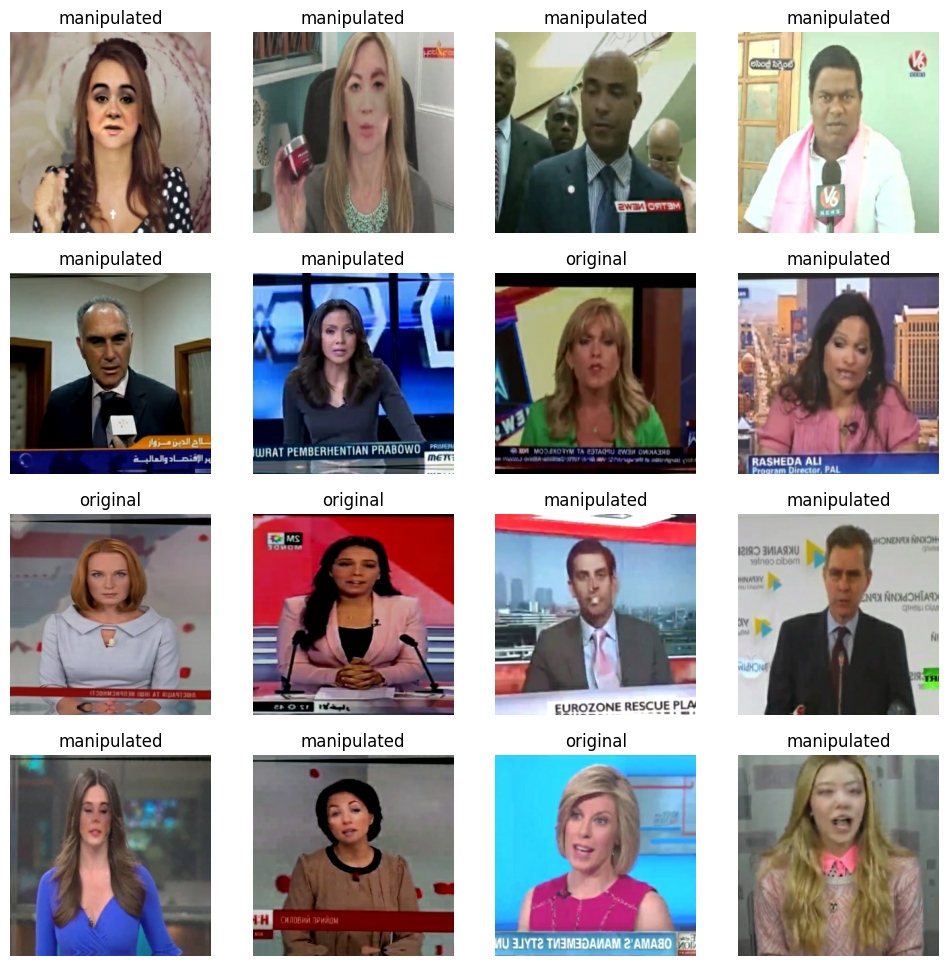

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in training_dataset.take(1):
  for i in range(16):
    tensor = labels[i].numpy()
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i])
    plt.title(CONFIGURATION["CLASS_NAMES"][int(tensor.item())])
    plt.axis("off")

## Xception

In [ ]:
class Convolution(Layer):
  def __init__(self, n_filters, kernel_size, n_strides=1):
    super(Convolution, self).__init__(name = "convolution")
    self.convolution = Conv2D(filters = n_filters, kernel_size = kernel_size, strides = n_strides, padding = "same",  activation = "relu")
    self.batch_normalization = BatchNormalization()

  def call(self, x, training = True):
    x = self.convolution(x)
    x = self.batch_normalization(x, training = training)
    return x


In [ ]:
class SeparableConvolution(Layer):
  def __init__(self, n_filters, kernel_size, n_strides=1):
    super(SeparableConvolution, self).__init__(name="separable_convolution")
    self.separable_convolution = SeparableConv2D(filters=n_filters, kernel_size=kernel_size, strides=n_strides, padding="same", activation=None)
    self.batch_normalization = BatchNormalization()

  def call(self, x, training=True):
    x = self.separable_convolution(x)
    x = self.batch_normalization(x, training=training)
    return x

In [ ]:
class SumConvolution(Layer):
  def __init__(self, n_filters, kernel_size, n_strides=1):
    super(SumConvolution, self).__init__(name = "sum_convolution")
    self.sum_convolution = Conv2D(filters = n_filters, kernel_size = kernel_size, strides = n_strides, padding = "same",  activation = None)
    self.batch_normalization = BatchNormalization()

  def call(self, x, training = True):
    x = self.sum_convolution(x)
    x = self.batch_normalization(x, training = training)
    return x

In [ ]:
class EntryFlow(Layer):
    def __init__(self, filters):
        super(EntryFlow, self).__init__(name="entry_flow")
        self.convolution1 = Convolution(filters[0], 3, 2)
        self.convolution2 = Convolution(filters[1], 3)

        self.sum_convolution1 = Convolution(filters[2], 1, 2)

        self.separable_convolution1 = SeparableConvolution(filters[2], 3)
        self.activation = ReLU()
        self.separable_convolution2 = SeparableConvolution(filters[2], 3)
        self.max_pooling = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.sum_convolution2 = Convolution(filters[3], 1, 2)

        self.separable_convolution3 = SeparableConvolution(filters[3], 3)
        self.separable_convolution4 = SeparableConvolution(filters[3], 3)

        self.sum_convolution3 = Convolution(filters[4], 1, 2)

        self.separable_convolution5 = SeparableConvolution(filters[4], 3)
        self.separable_convolution6 = SeparableConvolution(filters[4], 3)

    def call(self, x, training=True):
        x = self.convolution1(x, training = training)
        x = self.convolution2(x, training = training)
        tensor = self.sum_convolution1(x, training = training)

        x = self.separable_convolution1(x, training = training)
        x = self.activation(x)
        x = self.separable_convolution2(x, training = training)
        x = self.max_pooling(x)

        x = Add()([tensor, x])
        tensor = self.sum_convolution2(x, training = training)

        x = self.activation(x)
        x = self.separable_convolution3(x, training = training)
        x = self.activation(x)
        x = self.separable_convolution4(x, training = training)
        x = self.max_pooling(x)

        x = Add()([tensor, x])
        tensor = self.sum_convolution3(x, training = training)

        x = self.activation(x)
        x = self.separable_convolution5(x, training = training)
        x = self.activation(x)
        x = self.separable_convolution6(x, training = training)
        x = self.max_pooling(x)

        x = Add()([tensor, x])

        return x

In [ ]:
class MiddleFlow(Layer):
    def __init__(self, filters):
        super(MiddleFlow, self).__init__(name="middle_flow")
        self.activation = ReLU()
        self.separable_convolution1 = SeparableConvolution(filters[4], 3)
        self.separable_convolution2 = SeparableConvolution(filters[4], 3)
        self.separable_convolution3 = SeparableConvolution(filters[4], 3)

    def call(self, x, tensor, training=True):
        for i in range(8):
            x = self.activation(x)
            x = self.separable_convolution1(x, training = training)
            x = self.activation(x)
            x = self.separable_convolution2(x, training = training)
            x = self.activation(x)
            x = self.separable_convolution3(x, training = training)
            x = Add()([tensor, x])
        return x

In [ ]:
class ExitFlow(Layer):
  def __init__(self, filters):
    super(ExitFlow, self).__init__(name = "exit_flow")
    self.sum_convolution = SumConvolution(filters[5], 1, 2)

    self.activation = ReLU()
    self.separable_convolution1 = SeparableConvolution(filters[4], 3)
    self.separable_convolution2 = SeparableConvolution(filters[5], 3)
    self.max_pooling = MaxPool2D(pool_size = (3,3), strides = 2, padding = "same")

    self.separable_convolution3 = SeparableConvolution(filters[6], 3)
    self.separable_convolution4 = SeparableConvolution(filters[7], 3)
    self.global_average_pooling = GlobalAveragePooling2D()

    #Optionally one may insert fully-connected layers beffore the logistic regression layer, which is explored in the experimental evaluation section (in particular, see figures 7 and 8)

  def call(self, x, tensor, training = True):
    tensor = self.sum_convolution(tensor, training = training)

    x = self.activation(x)
    x = self.separable_convolution1(x, training = training)
    x = self.activation(x)
    x = self.separable_convolution2(x, training = training)
    x = self.max_pooling(x)

    x = Add()([tensor, x])

    x = self.separable_convolution3(x, training = training)
    x = self.activation(x)
    x = self.separable_convolution4(x, training = training)
    x = self.activation(x)
    x = self.global_average_pooling(x)

    return x



In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class XceptionNet(Model):
    def __init__(self, filters, trainable=True, name="xception_net", **kwargs):
        super(XceptionNet, self).__init__(name=name, **kwargs)
        self.entry_flow = EntryFlow(filters)
        self.middle_flow = MiddleFlow(filters)
        self.exit_flow = ExitFlow(filters)
        self.dense = Dense(1, activation="sigmoid")
        self.trainable = trainable
        self.filters = filters

    def call(self, x, training=True):
        x = self.entry_flow(x, training=training)
        tensor = x
        x = self.middle_flow(x, tensor, training=training)
        tensor = x
        x = self.exit_flow(x, tensor, training=training)
        x = self.dense(x)
        return x

    def summary(self):
        x = Input(shape=(299, 299, 3))
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

    def get_config(self):
        config = super(XceptionNet, self).get_config()
        config.update({
            "filters": self.filters,
            "trainable": self.trainable
        })
        return config

    @classmethod
    def from_config(cls, config):
        filters = config.pop('filters')
        return cls(filters=filters, **config)



## Training

In [ ]:
train = [16,32,64,128,364,512,768,1024]

In [ ]:
adam_optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"])

In [ ]:
total_examples = 944585
manipulated_examples = 738058
original_examples = 206527
manipulated_weight = total_examples/manipulated_examples
original_weight = total_examples/original_examples
class_weights = {0: original_weight, 1: manipulated_weight}
class_weights

{0: 4.573663491940521, 1: 1.2798248918106707}

In [ ]:
loss_fn = BinaryCrossentropy()

In [ ]:
metrics = [BinaryAccuracy(name = "accuracy"),
           Recall(name = "recall"),
           AUC(name = "auc")
           ]

In [ ]:
history = model.fit (
training_dataset, validation_data = validation_dataset, epochs = 14, steps_per_epoch = 29400, validation_steps = 3500, callbacks = [es_callback, tensorboard_callback], class_weight = class_weights
)


Epoch 1/14
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2221s 76ms/step - accuracy: 0.6230 - auc: 0.6950 - loss: 1.2362 - recall: 0.6142 - val_accuracy: 0.7090 - val_auc: 0.7828 - val_loss: 0.6142 - val_recall: 0.7077
Epoch 2/14
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2145s 73ms/step - accuracy: 0.7936 - auc: 0.8943 - loss: 0.8084 - recall: 0.7792 - val_accuracy: 0.7591 - val_auc: 0.7853 - val_loss: 0.5460 - val_recall: 0.8049
Epoch 3/14
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 1923s 65ms/step - accuracy: 0.8431 - auc: 0.9367 - loss: 0.6299 - recall: 0.8295 - val_accuracy: 0.7016 - val_auc: 0.8069 - val_loss: 0.7185 - val_recall: 0.6812
Epoch 4/14
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2007s 68ms/step - accuracy: 0.8735 - auc: 0.9566 - loss: 0.5209 - recall: 0.8618 - val_accuracy: 0.6284 - val_auc: 0.8123 - val_loss: 1.1266 - val_recall: 0.5612
Epoch 5/14
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2008s 68ms/step - accuracy: 0.8951 - auc: 0.9688 - loss: 0.4412 - recall: 0.8854 - val_accuracy: 0.7170 - val_auc: 0.8153 - val_loss

## Train

In [ ]:
model = XceptionNet(train)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow (EntryFlow)    │ (None, 19, 19, 364)    │        287,280 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ middle_flow (MiddleFlow)  │ (None, 19, 19, 364)    │        412,776 │ entry_flow[0][0],      │
│                           │                        │                │ entry_flow[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ exit_flow (ExitFlow)      │ (None, 1024)           │      1,718,852 │ middle_flow[0][0],     │
│                           │                        │                │ middle_flow[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │          1,025 │ exit_flow[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,419,933 (9.23 MB)

 Trainable params: 2,407,957 (9.19 MB)

 Non-trainable params: 11,976 (46.78 KB)

In [ ]:
log_dir = "drive/MyDrive/DeepFake Detection/logs/train_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [ ]:
model.compile(loss = loss_fn, optimizer = adam_optimizer, metrics = metrics)


In [ ]:
history = model.fit (
training_dataset, validation_data = validation_dataset, epochs = 15, steps_per_epoch = 29400, validation_steps = 3500, callbacks = [es_callback, tensorboard_callback], class_weight = class_weights
)


Epoch 1/15
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2166s 71ms/step - accuracy: 0.5512 - auc: 0.5928 - loss: 1.3489 - recall: 0.5430 - val_accuracy: 0.7350 - val_auc: 0.6883 - val_loss: 0.5313 - val_recall: 0.8240
Epoch 2/15
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2137s 73ms/step - accuracy: 0.6970 - auc: 0.7952 - loss: 1.0844 - recall: 0.6812 - val_accuracy: 0.7199 - val_auc: 0.7184 - val_loss: 0.5491 - val_recall: 0.7648
Epoch 3/15
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2105s 72ms/step - accuracy: 0.7582 - auc: 0.8670 - loss: 0.8961 - recall: 0.7390 - val_accuracy: 0.7728 - val_auc: 0.7290 - val_loss: 0.5038 - val_recall: 0.8741
Epoch 4/15
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2079s 71ms/step - accuracy: 0.7970 - auc: 0.9017 - loss: 0.7775 - recall: 0.7798 - val_accuracy: 0.7644 - val_auc: 0.7532 - val_loss: 0.4981 - val_recall: 0.8423
Epoch 5/15
29400/29400 ━━━━━━━━━━━━━━━━━━━━ 2080s 71ms/step - accuracy: 0.8219 - auc: 0.9222 - loss: 0.6947 - recall: 0.8058 - val_accuracy: 0.7461 - val_auc: 0.7373 - val_loss

In [ ]:
model.save("drive/MyDrive/DeepFake Detection/xception_net_train_2.keras")

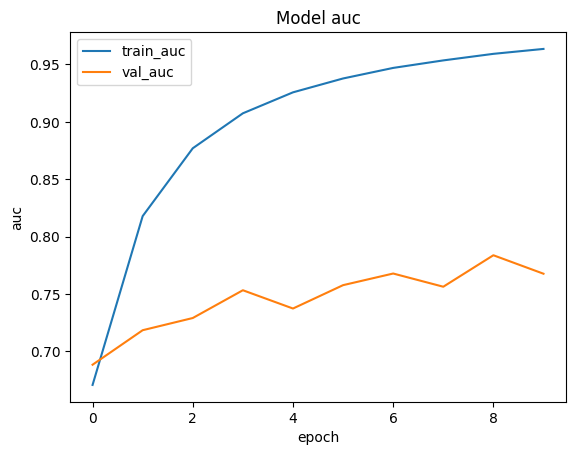

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train_auc', 'val_auc'])
plt.show()

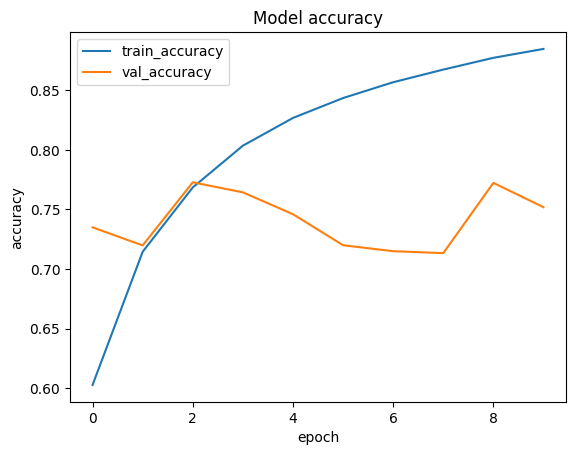

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

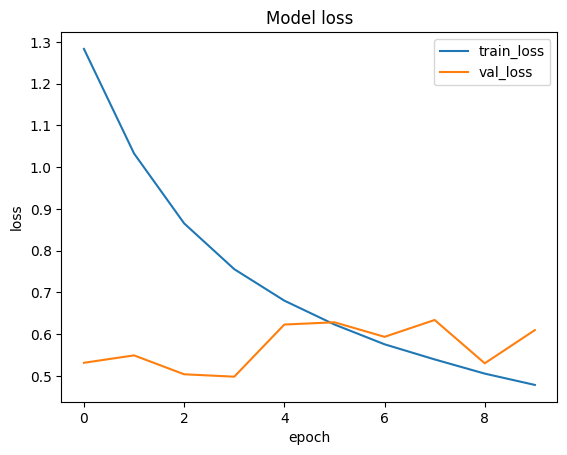

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Test

In [ ]:
class TrackFace():
  def __init__(self):
    self.model = YOLO('yolov8n.pt', verbose=False)
    self.total_frames_extracted = 0

  def track(self, frame):
    self.img_height, self.img_width, _ = frame.shape
    results = self.model(frame)
    face_box = self._get_face(results)
    cropped_frame = self._crop_face(frame, face_box)
    return cropped_frame

  def _get_face(self, results):
    main_face = None
    for res in results[0].boxes:
      if res.cls == 0:
        face_box = res.xyxy[0].cpu().numpy()
        main_face = self._get_main_face(main_face, face_box)
    if main_face is None:
      return [0, 0, self.img_width, self.img_height]
    return main_face

  def _get_main_face(self, main_face, face_box):
    if main_face is None:
      return face_box
    if self._get_area(face_box) > self._get_area(main_face):
      return face_box
    return main_face

  def _get_area(self, box):
    x1, y1, x2, y2 = box
    area = (x2 - x1) * (y2 - y1)
    return area

  def _crop_face(self, frame, face_box):
    extended_box = self._extend_box(face_box)
    x1, y1, x2, y2 = extended_box
    cropped_face = frame[y1:y2, x1:x2]
    return cropped_face

  def _extend_box(self, box, factor=1.3):
    x1, y1, x2, y2 = box
    box_width, box_height = x2 - x1, y2 - y1
    center_x, center_y = self._calculate_center(box)
    extended_box_width, extended_box_height = self._calculate_new_dimensions(box_width, box_height, factor)
    return self._calculate_new_coordinates(center_x, center_y, extended_box_width, extended_box_height )

  def _calculate_center(self, box):
    x1, y1, x2, y2 = box
    center_x = x1 + (x2 - x1) / 2
    center_y = y1 + (y2 - y1) / 2
    return center_x, center_y

  def _calculate_new_dimensions(self, width, height, factor):
    extended_box_width = width * factor
    extended_box_height = height * factor
    return extended_box_width, extended_box_height

  def _calculate_new_coordinates(self, center_x, center_y, extended_box_width, extended_box_height):
    extended_x1 = max(0, int(center_x - extended_box_width / 2))
    extended_y1 = max(0, int(center_y - extended_box_height / 2))
    extended_x2 = min(self.img_width, int(center_x + extended_box_width / 2))
    extended_y2 = min(self.img_height, int(center_y + extended_box_height / 2))
    return extended_x1, extended_y1, extended_x2, extended_y2

In [ ]:
def predict(video_url):
  count_original = 0
  count_manipulated = 0
  capture = cv2.VideoCapture(video_url)
  if not capture.isOpened():
    print("Errore: impossibile aprire il file video")
    return
  tensors = create_frame_tensor(capture)
  capture.release()
  predictions = []
  for tensor in tensors:
    frame_prediction = model.predict(tensor)
    print(frame_prediction)
    if frame_prediction < 0.56:
      frame_prediction = "original"
      count_original += 1
    else:
      frame_prediction = "manipulated"
      count_manipulated += 1
    predictions.append(frame_prediction)
  result = max(set(predictions), key=predictions.count)
  return result, count_original, count_manipulated

def create_frame_tensor(capture):
  track_face = TrackFace()
  frame_count = 0
  frame_tensors = []
  while True:
    is_a_frame, frame = capture.read()
    if not is_a_frame:
      break
    cropped_frame = track_face.track(frame)
    tensor = tf.convert_to_tensor(cropped_frame, dtype=tf.float32)
    resize_tensor = tf.keras.Sequential([
       Resizing(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
       Rescaling(1./255),
    ])
    tensor = tf.convert_to_tensor(cropped_frame, dtype=tf.float32)
    tensor = tf.expand_dims(tensor, axis=0)

    frame_tensors.append(resize_tensor(tensor))
  return frame_tensors


In [ ]:
model = load_model("drive/MyDrive/DeepFake Detection/xception_net_train_2.keras")

In [ ]:
results = model.evaluate(test_dataset, steps = 3500)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

3500/3500 ━━━━━━━━━━━━━━━━━━━━ 173s 48ms/step - accuracy: 0.7578 - auc: 0.7542 - loss: 0.5180 - recall: 0.8158
Test Loss: 0.5210281014442444
Test Accuracy: 0.7562510371208191


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.95474434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.0028836806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.9999896
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.08653853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.9999993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.5152051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.1891602
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.99869484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.03908155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.08115666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.7385383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.0055762725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.97098213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.66267866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.3061568
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.99009037


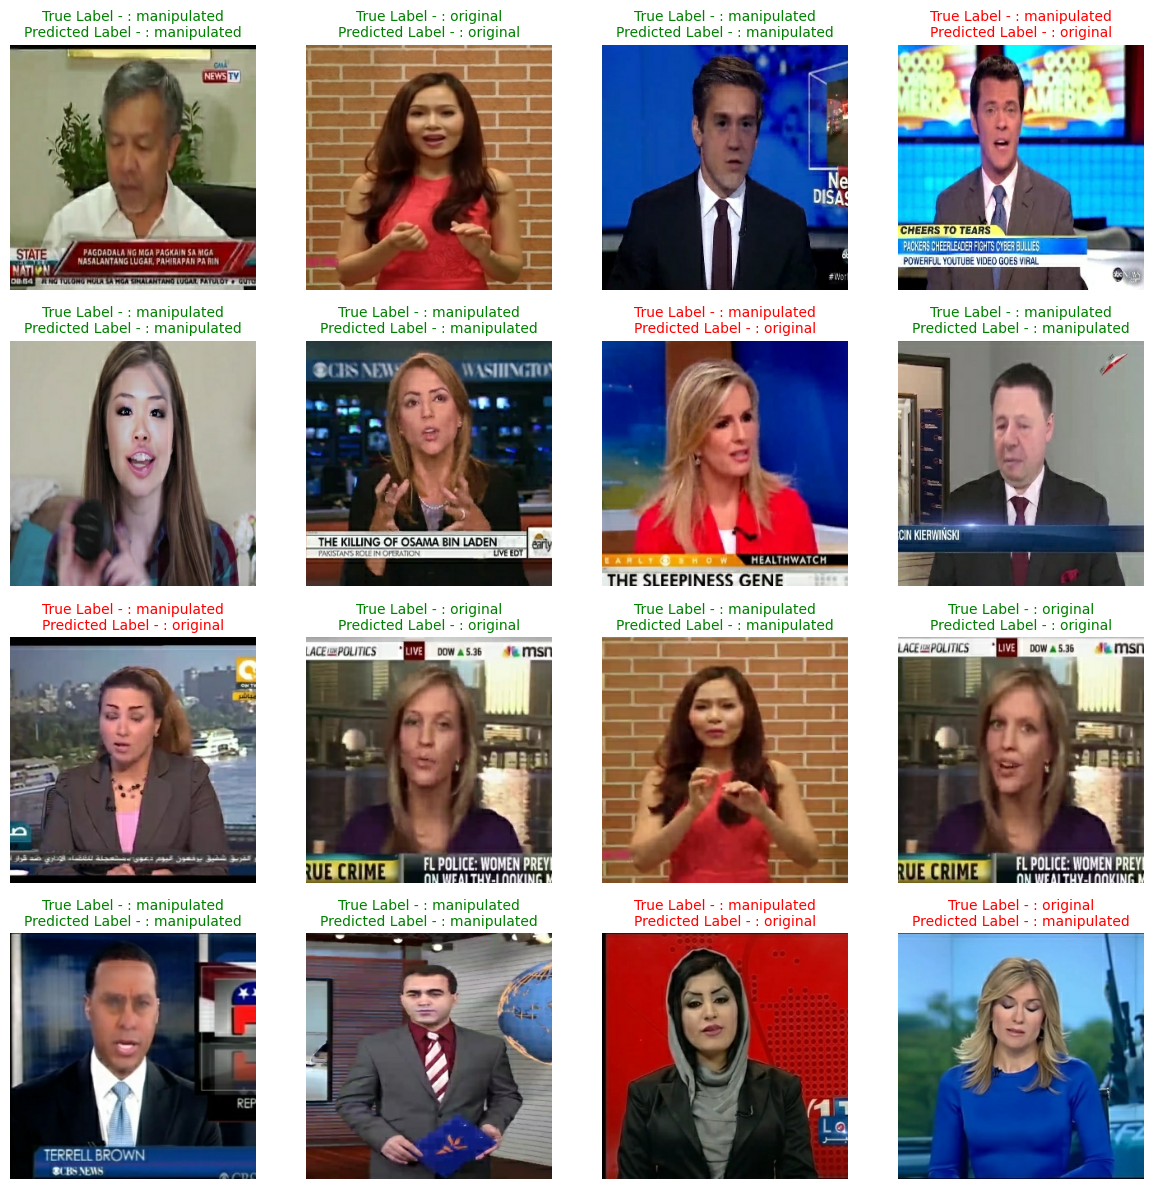

In [ ]:
plt.figure(figsize=(12, 12))

for images, labels in test_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        true_label = int(labels[i].numpy())
        predicted_prob = model.predict(tf.expand_dims(images[i], axis=0))[0][0]
        predicted_label = int(predicted_prob >= 0.50)

        if true_label == predicted_label:
            color = "green"
        else:
            color = "red"

        plt.title(
            "True Label - : " + CONFIGURATION["CLASS_NAMES"][true_label]
            + "\n" + "Predicted Label - : " + CONFIGURATION["CLASS_NAMES"][predicted_label],
            color=color, fontsize=10
        )
        plt.axis("off")

plt.tight_layout() 
plt.show()


In [ ]:
import math

predicted = []
labels = []

for im, label in test_dataset:
    predictions = model(im)
    truncated_predictions = np.trunc(predictions.numpy() * 100) / 100
    predicted.append(truncated_predictions)
    labels.append(label.numpy())

predicted = np.concatenate(predicted).flatten()
labels = np.concatenate(labels).flatten()


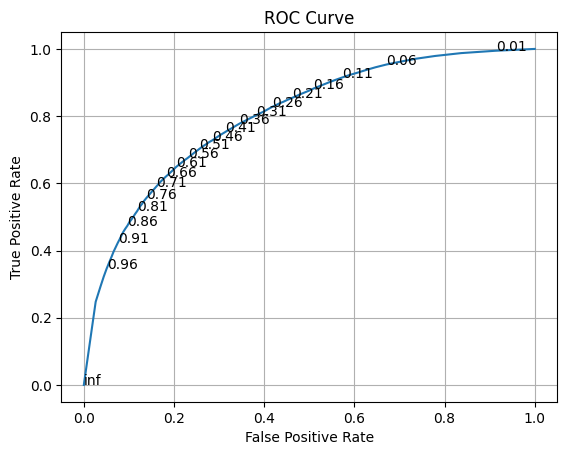

In [ ]:
from sklearn.metrics import roc_curve, auc


fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

skip = 5
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()

In [ ]:
test = "drive/MyDrive/DeepFake Detection/test/obama.mp4"

In [ ]:
prediction, count_original, count_manipulated = predict(test)
total = count_original + count_manipulated
print(f"Risultato finale: {prediction}")
print(f"probabilità che sia originale: {(count_original/total*100):2f}%")
print(f"probabilità che sia manipolato: {(count_manipulated/total*100):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[    0.65979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[    0.65979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[    0.65979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[    0.65979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.66714]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.65979]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.92414]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.96791]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[    0.98056]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.99569]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.99669]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[    0.99746]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.99788]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[    0.99741]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.99758]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.99761]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.99749]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[    0.99732]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21